This notebook is based on the ktrain [tutorial-06-sequence-tagging](https://github.com/amaiya/ktrain/blob/master/tutorials/tutorial-06-sequence-tagging.ipynb) notebook.

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIbBLE_DEVICES"]="0"; 

*ktrain* uses TensorFlow 2.  To support sequence-tagging, *ktrain* also currently uses the CRF module from `keras_contrib`, which is not yet fully compatible with TensorFlow 2.
To use the BiLSTM-CRF model (which currently requires `keras_contrib`) for sequence-tagging in *ktrain*, you must disable V2 behavior in  TensorFlow 2
by adding the following line to the top of your notebook or script **before** importing *ktrain*:
```python
import os
os.environ['DISABLE_V2_BEHAVIOR'] = '1'
```
Since we are employing a CRF layer in this notebook, we will set this value here:

In [6]:
import ktrain
from ktrain import text

# Sequence Tagging

Sequence tagging (or sequence labeling) involves classifying words or sequences of words as representing some category or concept of interest.  One example of sequence tagging is Named Entity Recognition (NER), where we classify words or sequences of words that identify some entity such as a person, organization, or location.  In this tutorial, we will show how to use *ktrain* to perform sequence tagging in three simple steps.

## STEP 1: Load and Preprocess Data

The `entities_from_txt` function can be used to load tagged sentences from a text file.  The text file can be in one of two different formats: 1) the [CoNLL2003 format](https://www.aclweb.org/anthology/W03-0419) or 2) the [Groningen Meaning Bank (GMB) format](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus). In both formats, there is one word and its associated tag on each line (where the word and tag are delimited by a space, tab or comma).  Words are ordered as they appear in the sentence.  In the CoNLL2003 format, there is a blank line that delineates sentences.  In the GMB format, there is a third column for Sentence ID that assignes a number to each row indicating the sentence to which the word belongs.  If you are building a sequence tagger for your own use case with the `entities_from_txt` function, the training data should be formatted into one of these two formats. Alternatively, one can use the `entities_from_aray` function which simply expects arrays of the following form:
```python
x_train = [['Hello', 'world', '!'], ['Hello', 'Barack', 'Obama'], ['I', 'love', 'Chicago']]
y_train = [['O', 'O', 'O'], ['O', 'B-PER', 'I-PER'], ['O', 'O', 'B-LOC']]
```
Note that the tags in this example follow the [IOB2 format](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)).

In this notebook, we will be using `entities_from_txt`  and build a sequence tagger using the Groningen Meaning Bank NER dataset available on Kaggle [here](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus). The format essentially looks like this (with fields being delimited by comma):
```
      SentenceID   Word     Tag    
      1            Paul     B-PER
      1            Newman   I-PER
      1            is       O
      1            a        O
      1            great    O
      1            actor    O
      1            .        O
 ```

We will be using the file `ner_dataset.csv` (which conforms to the format above) and will load and preprocess it using the `entities_from_txt` function.  The output is simlar to data-loading functions used in previous tutorials and includes the processed training set, processed validaton set, and an instance of `NERPreprocessor`.  

The Kaggle dataset `ner_dataset.csv` the three columns of interest (mentioned above) are labeled 'Sentence #', 'Word', and 'Tag'.  Thus, we specify these in the call to the function.

### Questions regarding text.entities_from_text

Inputs
* use_char - If True, data will be preprocessed to use character embeddings in addition to word embeddings
  * The version of TF2 that we use has a bug that prevents from using character encodings. Is this helping to improve the learning process?

In [7]:
DATAFILE = 'c:/Users/kostobog/Documents/skola/projects/2019-msmt-inter-excelence/partners/nlp-corpus/components-for-ner.csv'
(trn, val, preproc) = text.entities_from_txt(DATAFILE,
                                             sentence_column='Sentence #',
                                             word_column='Word',
                                             tag_column='Tag', 
                                             data_format='gmb',
                                             use_char=True,
                                             val_pct=0.1
                                            )

detected encoding: utf-8 (if wrong, set manually)
Number of sentences:  2901
Number of words in the dataset:  3222
Tags: ['I-component', 'O', 'B-component', 'B-null']
Number of Labels:  4
Longest sentence: 93 words


In [8]:
# trn.xshape()
trn.nsamples()
# val.nsamples()

2610

When loading the dataset above, we specify `use_char=True` to instruct *ktrain* to extract the character vocabulary to be used in a character embedding layer of a model.

## STEP 2:  Define a Model

The `print_sequence_taggers` function shows that, as of this writing, *ktrain* currently supports both Bidirectional LSTM-CRM and Bidirectional LSTM as base models for sequence tagging. Theses base models can be used with different embedding schemes.

For instance, the `bilstm-bert` model employs [BERT word embeddings](https://arxiv.org/abs/1810.04805) as features for a Bidirectional LSTM. See [this notebook](https://github.com/amaiya/ktrain/blob/master/examples/text/CoNLL2002_Dutch-BiLSTM.ipynb) for an example of `bilstm-bert`.  In this tutorial, we will use a Bidirectional LSTM model with a CRF layer. 

In [9]:
text.print_sequence_taggers()

bilstm: Bidirectional LSTM (https://arxiv.org/abs/1603.01360)
bilstm-bert: Bidirectional LSTM w/ BERT embeddings
bilstm-crf: Bidirectional LSTM-CRF  (https://arxiv.org/abs/1603.01360)
bilstm-elmo: Bidirectional LSTM w/ Elmo embeddings [English only]
bilstm-crf-elmo: Bidirectional LSTM-CRF w/ Elmo embeddings [English only]


### Questions sequence_tagger
**Inputs**
* bert_layers_to_use - indices of hidden layers to use.  default:[-2] # second-to-last layer
                              To use the concatenation of last 4 layers: use [-1, -2, -3, -4]
  * How are the layers used? 
  * How many layers we should use? Is there a method how to choose the number of layers?
*  fasttext and bert embeddings set by parameters *wv_path_or_url* and *bert_model*
  * These word embeddings combined using concatenation. 
  * Do you combined word embeddings in your NER pipeline? 
  * If yes, do you further process concatenated word embeddings to remove redundancy, e.g. using PCA, see [merging-two-word-embedding-models](https://stats.stackexchange.com/questions/315272/merging-two-word-embedding-models), [ConceptNet at SemEval-2017 Task 2: Extending Word Embeddings with
Multilingual Relational Knowledge
](https://arxiv.org/pdf/1704.03560.pdf)

In [10]:
WV_URL = 'https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz'
model = text.sequence_tagger('bilstm-bert', preproc, wv_path_or_url=WV_URL, bert_model='bert-base-cased')

C:\apps\anaconda3\envs\base-clone\lib\site-packages\ktrain\text\ner\models.py:122: UserWarning: Setting use_char=False:  character embeddings cannot be used in TF2 due to open TensorFlow 2 bug (#33148).
Add os.environ["DISABLE_V2_BEHAVIOR"] = "1" to the top of script if you really want to use it.
  warnings.warn('Setting use_char=False:  character embeddings cannot be used in TF2 due to open TensorFlow 2 bug (#33148).\n' +\


Embedding schemes employed (combined with concatenation):
	word embeddings initialized with fasttext word vectors (cc.en.300.vec)
	BERT embeddings with bert-base-cased

pretrained word embeddings will be loaded from:
	c:/Users/kostobog/ktrain_data/cc.en.300.vec
loading pretrained word vectors...this may take a few moments...


In the cell above, notice that we suppied the `wv_path_or_url` argument. This directs *ktrain* to initialized word embeddings with one of the pretrained fasttext (word2vec) word vector sets from [Facebook's fastttext site](https://fasttext.cc/docs/en/crawl-vectors.html).   When supplied with a valid URL to a `.vec.gz`, the word vectors will be automatically downloaded, extracted, and loaded in STEP 2 (download location is `<home_directory>/ktrain_data`). To disable pretrained word embeddings, set `wv_path_or_url=None` and randomly initialized word embeddings will be employed. Use of pretrained embeddings will typically boost final accuracy. When used in combination with a model that uses an embedding scheme like BERT (e.g., `bilstm-bert`), the different word embeddings are stacked together using concatenation.

Finally, we will wrap our selected model and datasets in a `Learner` object to facilitate training.

### Questions regarding ktrain.get_learner
* batch_size - Can you give us advice on how to properly select the batch_size?

In [11]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=32)

## STEP 3: Train and Evaluate the Model

Here, we will train for a single epoch using an initial learning rate of 0.01 with gradual decay using cosine annealing (via the `cycle_len=1`) parameter and see how well we do. The learning rate of `0.01` is determined with the learning-rate-finder (i.e., `lr_find`).

In [9]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
preparing training data ...done.
Epoch 1/1024
81/81 [==============================] - 454s 6s/step - loss: 0.6274
Epoch 2/1024
81/81 [==============================] - 438s 5s/step - loss: 0.6203
Epoch 3/1024
81/81 [==============================] - 442s 5s/step - loss: 0.6024
Epoch 4/1024
81/81 [==============================] - 444s 5s/step - loss: 0.5653
Epoch 5/1024
81/81 [==============================] - 447s 6s/step - loss: 0.4872
Epoch 6/1024
81/81 [==============================] - 446s 5s/step - loss: 0.3587
Epoch 7/1024
81/81 [==============================] - 443s 5s/step - loss: 0.2225
Epoch 8/1024
81/81 [==============================] - 445s 5s/step - loss: 0.1556
Epoch 9/1024
81/81 [==============================] - 461s 6s/step - loss: 0.1244
Epoch 10/1024
81/81 [==============================] - 441s 5s/step - loss: 0.0980
Epoch 11/1024
81/81 [==============================] - 433s 5s/

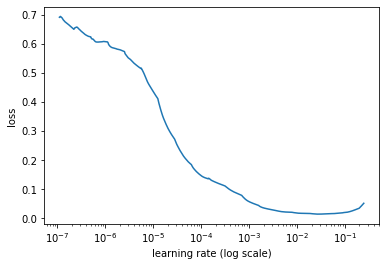

In [10]:
learner.lr_plot()

### Questions regarding learning rate (LR) selection
Consider the graph above. Is it ok to select LR of 0.02? Is the loss increasing between 1e-7 and 1e-6 indicatoin to select a lower learning rate?

In [11]:
learner.fit(1e-2, 1, cycle_len=1)

preparing validation data ...done.
82/82 [==============================] - 477s 6s/step - loss: 0.0712 - val_loss: 0.0344


In [12]:
learner.validate()

   F1:  72.39
              precision    recall  f1-score   support

   component       0.75      0.71      0.73       272
        null       0.00      0.00      0.00         4

   micro avg       0.75      0.70      0.72       276
   macro avg       0.37      0.36      0.36       276
weighted avg       0.74      0.70      0.72       276



0.7238805970149254

Our F1-score is **84.19** after a single pass through the dataset. Not bad for a single epoch of training.

Let's invoke `view_top_losses` to see the sentence we got the most wrong. This single sentence about James Brown contains 10 words that are misclassified.  We can see here that our model has trouble with titles of songs. In addition, some of the ground truth labels for this example are sketchy and incomplete, which also makes things difficult.

In [13]:
learner.view_top_losses(n=1)

total incorrect: 5
Word            True : (Pred)
In             :O     (O)
case           :O     (O)
of             :O     (O)
an             :O     (O)
internal       :O     (O)
error          :O     (O)
during         :O     (O)
operation      :O     (O)
or             :O     (O)
the            :O     (O)
loss           :O     (O)
of             :O     (O)
a              :O     (O)
sensor         :B-component (B-component)
signal         :O     (O)
the            :O     (O)
system         :O     (O)
automatically  :O     (O)
switches       :B-component (O)
to             :O     (O)
ECU            :B-component (B-component)
B              :I-component (O)
.              :O     (O)
If             :O     (O)
the            :O     (O)
loss           :O     (O)
of             :O     (O)
the            :O     (O)
sensor         :B-component (B-component)
signal         :O     (O)
was            :O     (O)
the            :O     (O)
cause          :O     (O)
for            :O     (O)
the    

## Making Predictions on New Sentences

Let's use our model to extract entities from new sentences. We begin by instantating a `Predictor` object.

In [61]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [93]:
predictor.predict('A rod end bearing is screwed into a steel push rod and locked by means of a jam nut which has locking varnish applied to it.')

[('A', 'O'),
 ('rod', 'B-component'),
 ('end', 'O'),
 ('bearing', 'I-component'),
 ('is', 'O'),
 ('screwed', 'O'),
 ('into', 'O'),
 ('a', 'O'),
 ('steel', 'B-component'),
 ('push', 'O'),
 ('rod', 'I-component'),
 ('and', 'O'),
 ('locked', 'O'),
 ('by', 'O'),
 ('means', 'O'),
 ('of', 'O'),
 ('a', 'O'),
 ('jam', 'B-component'),
 ('nut', 'I-component'),
 ('which', 'O'),
 ('has', 'O'),
 ('locking', 'O'),
 ('varnish', 'O'),
 ('applied', 'O'),
 ('to', 'O'),
 ('it', 'O'),
 ('.', 'O')]

We can save the predictor for later deployment.

In [18]:
predictor.save('/tmp/mypred')

In [19]:
reloaded_predictor = ktrain.load_predictor('/tmp/mypred')

C:\apps\anaconda3\envs\base-clone\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


The `predict` method also can accept a list of sentences.  And, larger batch sizes can potentially speed predictions when `predictor.predict` is supplied with a list of examples.

Both the `load_predictor` and `get_predictor` functions accept an optional `batch_size` argument used for predictions, which is set to 32 by default. The `batch_size` can also be set manually on the `Predictor` instance.  That is, the `batch_size` used for inference and predictions can be increased with either of the following:
```python
# you can set the batch_size as an argument to load_predictor (or get_predictor)
predictor = ktrain.load_predictor('/tmp/mypred', batch_size=128)

# you can also set the batch_size used for predictions this way
predictor.batch_size = 128
```
